In [1]:
import pandas as pd
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

In [2]:
from anki.collection import Collection


optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract("./Main_27.04.2023.apkg",
                       filter_out_suspended_cards, filter_out_flags)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False)

col = Collection("./collection.anki21")
decks = [item.name for item in tuple(col.decks.all_names_and_ids()) if sum([col.get_card(cid).reps for cid in col.find_cards(f"deck:{item.name}")]) >= 1000]

def remove_substrings(lst):
    # Sort the list by length of the strings, longest first
    lst.sort(key=len, reverse=True)

    # List to hold the filtered items
    filtered_list = []

    for item in lst:
        # Add the item to the filtered list if it is not a substring of any item already in the filtered list
        if not any(item in other_item for other_item in filtered_list):
            filtered_list.append(item)

    return filtered_list

decks_for_cluster = remove_substrings(decks)
df = pd.read_csv("./revlog_history.tsv", sep="\t", dtype={"first_rating": str})
dfs = [(name, df[df['card_id'].isin(tuple(col.find_cards(f"deck:{name}")))].copy(
)) for name in decks_for_cluster]

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.


In [3]:
ws = []
datasets = []

for name, df in dfs:
    optimizer.define_model()
    S0_dataset = df[df["i"] == 2].copy()
    optimizer.S0_dataset_group = (
        S0_dataset.groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.pretrain(df.copy(), verbose=False)
    optimizer.train(verbose=False)
    datasets.append(optimizer.dataset.copy())
    ws.append(optimizer.w)

  0%|          | 0/30819 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/22587 [00:00<?, ?it/s]

  0%|          | 0/1342 [00:00<?, ?it/s]

  0%|          | 0/5864 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/15200 [00:00<?, ?it/s]

  0%|          | 0/2292 [00:00<?, ?it/s]

  0%|          | 0/52207 [00:00<?, ?it/s]

  0%|          | 0/4587 [00:00<?, ?it/s]

log loss: 0.3510
RMSE(bins): 0.0290
R-squared: 0.9187
MAE: 0.0163
ICI: 0.0155
E50: 0.0102
E90: 0.0295
EMax: 0.2675
[0.1728357 0.8012902]

Last rating: 1
RMSE(bins): 0.0493
R-squared: 0.7376
MAE: 0.0513
ICI: 0.0477
E50: 0.0454
E90: 0.0888
EMax: 0.1925
[0.26016399 0.6771606 ]

Last rating: 2
RMSE(bins): 0.0396
R-squared: 0.9354
MAE: 0.0226
ICI: 0.0185
E50: 0.0179
E90: 0.0252
EMax: 0.1751
[0.08391222 0.8844703 ]

Last rating: 3
RMSE(bins): 0.0318
R-squared: 0.8700
MAE: 0.0133
ICI: 0.0118
E50: 0.0030
E90: 0.0314
EMax: 0.3056
[0.20660358 0.77281074]

Last rating: 4
RMSE(bins): 0.0372
R-squared: 0.3212
MAE: 0.0150
ICI: 0.0142
E50: 0.0077
E90: 0.0261
EMax: 0.1068
[0.33626042 0.66615514]


({'R-squared': 0.9187056498471055,
  'MAE': 0.016341318966228008,
  'ICI': 0.015486923280515708,
  'rmse': 0.028961735631548635},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

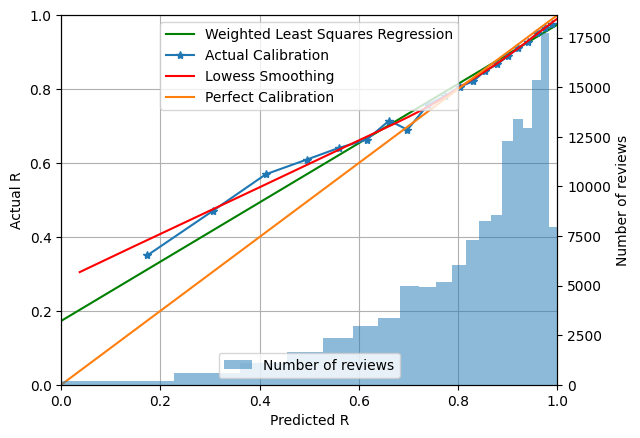

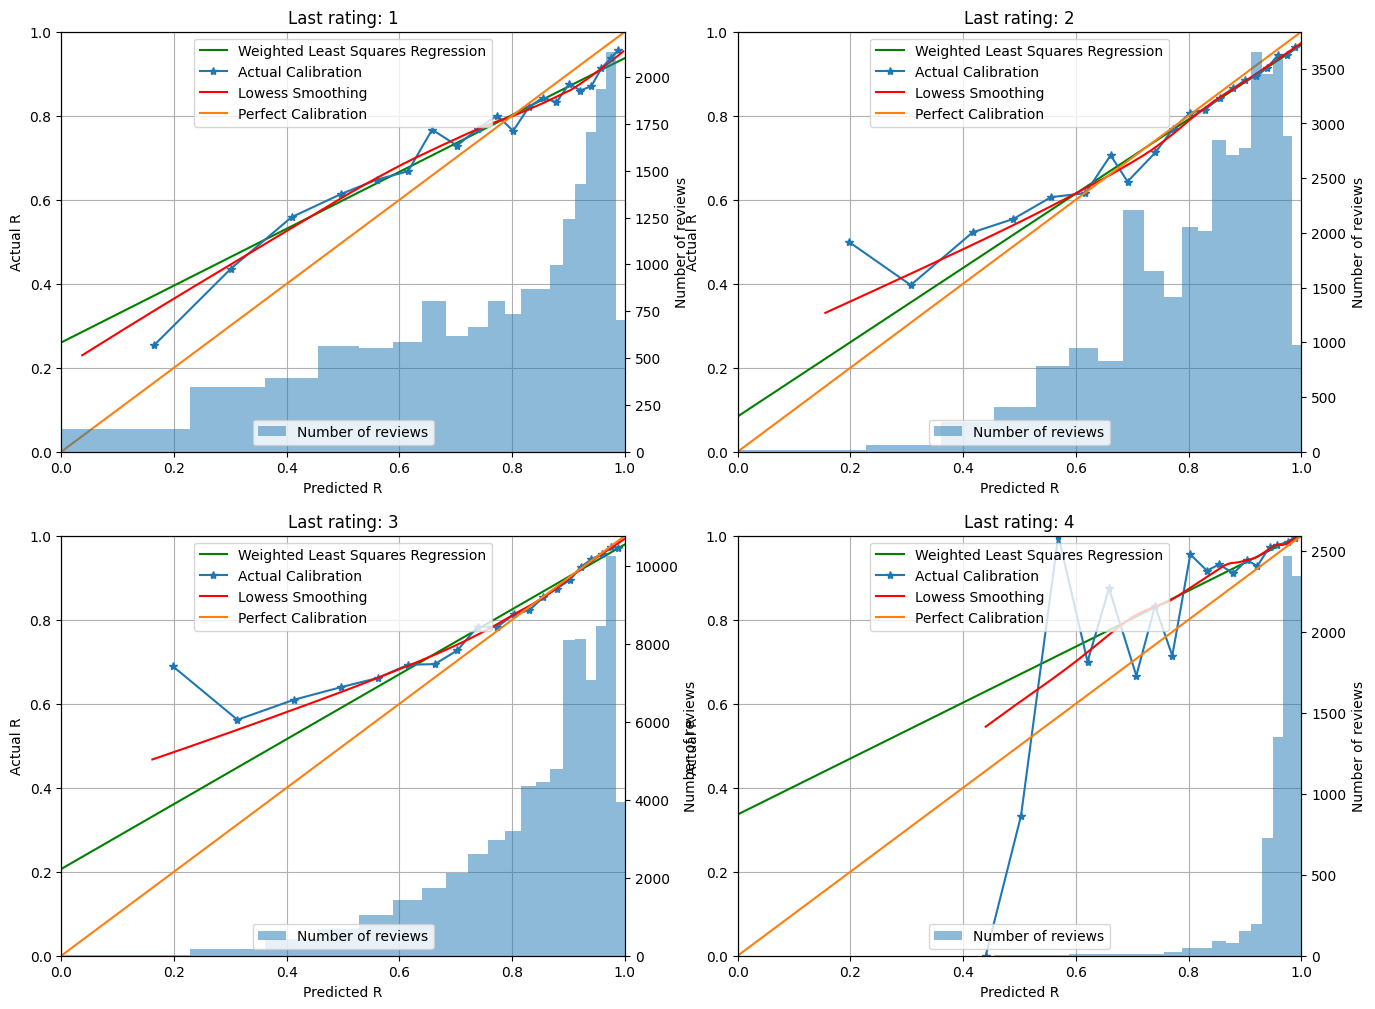

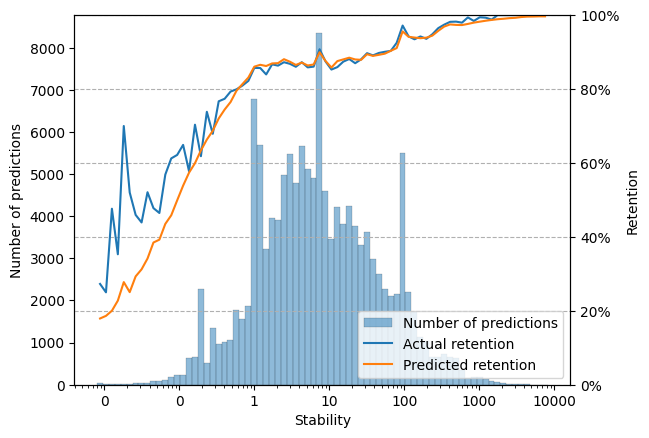

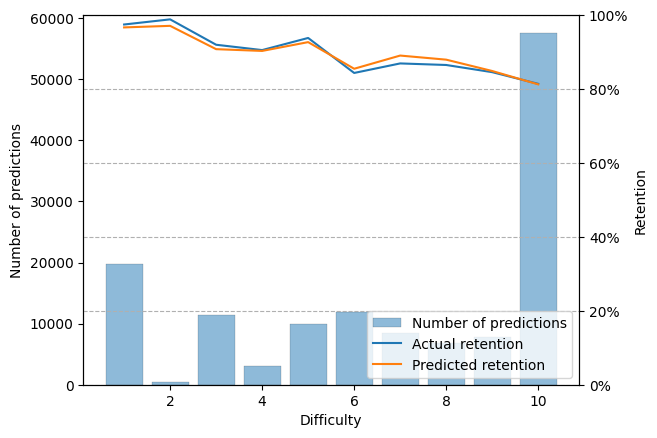

In [4]:
from fsrs_optimizer import Collection, power_forgetting_curve
from sklearn.metrics import log_loss

results = []

for w, dataset in zip(ws, datasets):
    my_collection = Collection(w)
    stabilities, difficulties = my_collection.batch_predict(dataset)
    dataset["stability"] = stabilities
    dataset["difficulty"] = difficulties
    dataset["p"] = power_forgetting_curve(dataset["delta_t"], dataset["stability"])
    results.append(dataset.copy())

dataset_join = pd.concat(results, ignore_index=True)
print(f"log loss: {log_loss(dataset_join['y'], dataset_join['p']):.4f}")
optimizer.calibration_graph(dataset_join)

  0%|          | 0/137144 [00:00<?, ?it/s]

log loss: 0.3614
RMSE(bins): 0.0349
R-squared: 0.8436
MAE: 0.0226
ICI: 0.0217
E50: 0.0154
E90: 0.0422
EMax: 0.3034
[0.23421275 0.73069422]

Last rating: 1
RMSE(bins): 0.0565
R-squared: 0.6951
MAE: 0.0530
ICI: 0.0500
E50: 0.0501
E90: 0.0851
EMax: 0.2043
[0.27589552 0.65615081]

Last rating: 2
RMSE(bins): 0.0444
R-squared: 0.7741
MAE: 0.0340
ICI: 0.0298
E50: 0.0252
E90: 0.0384
EMax: 0.3431
[0.20057542 0.74779311]

Last rating: 3
RMSE(bins): 0.0375
R-squared: 0.7792
MAE: 0.0193
ICI: 0.0187
E50: 0.0081
E90: 0.0481
EMax: 0.3046
[0.27007094 0.70128904]

Last rating: 4
RMSE(bins): 0.0351
R-squared: 0.2718
MAE: 0.0109
ICI: 0.0107
E50: 0.0033
E90: 0.0257
EMax: 0.0896
[0.38899944 0.60802195]


({'R-squared': 0.8435981590274471,
  'MAE': 0.022609128720526263,
  'ICI': 0.02170494511336304,
  'rmse': 0.034886734603517315},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

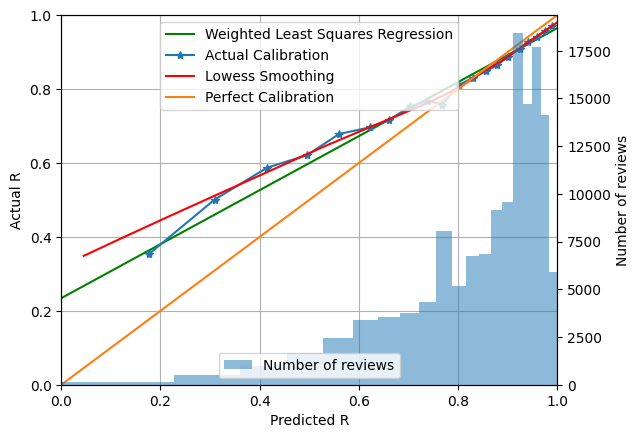

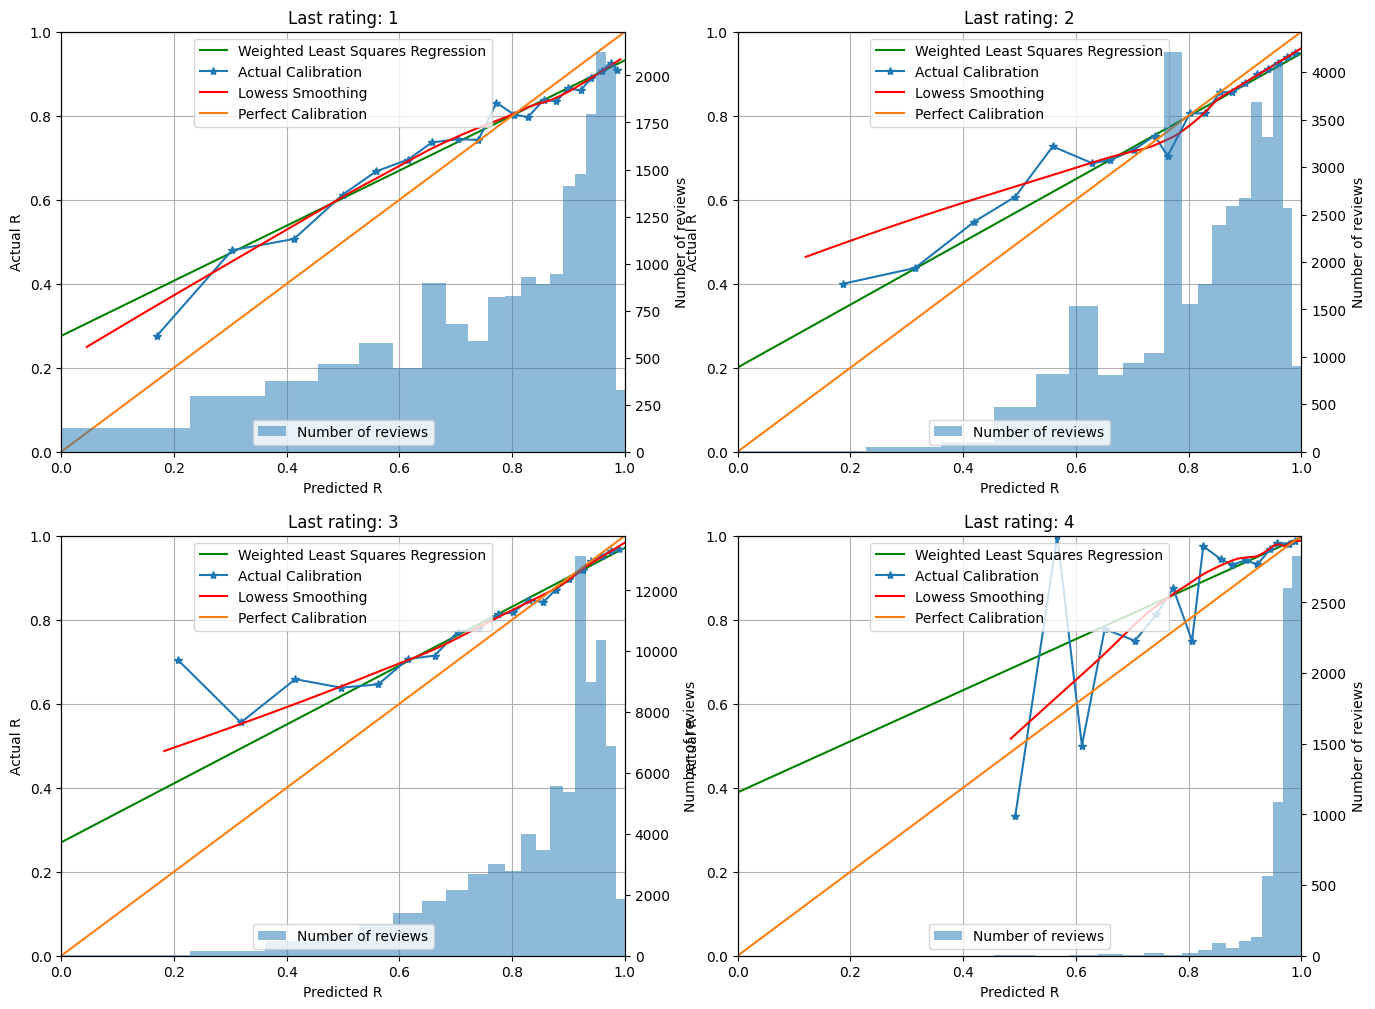

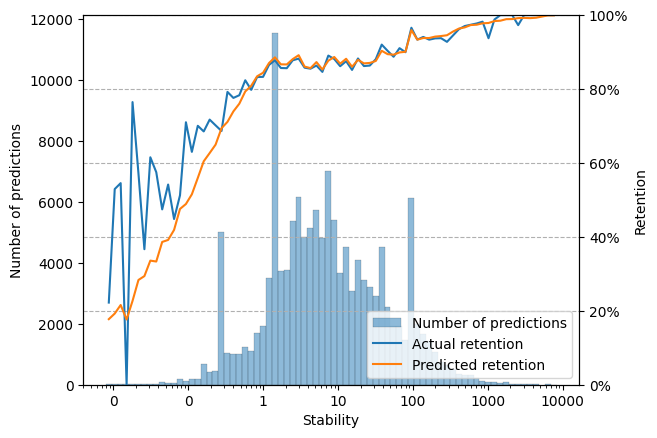

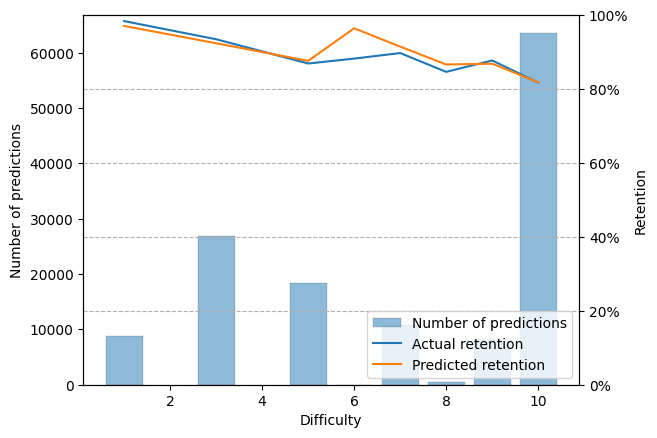

In [5]:
optimizer.define_model()
S0_dataset = dataset_join[dataset_join["i"] == 2].copy()
optimizer.S0_dataset_group = (
    S0_dataset.groupby(by=["first_rating", "delta_t"], group_keys=False)
    .agg({"y": ["mean", "count"]})
    .reset_index()
)
optimizer.pretrain(dataset_join.copy(), verbose=False)
optimizer.train(verbose=False)
optimizer.evaluate()
print(f"log loss: {log_loss(optimizer.dataset['y'], optimizer.dataset['p']):.4f}")
optimizer.calibration_graph()

In [6]:
for w, (name, df) in zip(ws, dfs):
    print(name, len(df), w, sep="\n")
    print()

print("Global", optimizer.w, sep="\n")

Main::Japanese::WaniKani::Vocabulary
34407
[1.0199, 0.2938, 1.3855, 19.4171, 7.0406, 0.5375, 0.7609, 0.0112, 1.7572, 0.1735, 1.2472, 2.094, 0.0539, 0.1813, 2.1234, 0.164, 4.0517, 0.6209, 1.1312]

Main::Programming::Python::Syntax
1131
[0.2856, 0.5082, 1.3103, 15.5993, 7.1378, 0.6154, 1.0095, 0.0, 1.6315, 0.1318, 1.0957, 2.0099, 0.0724, 0.3176, 2.1369, 0.2098, 3.1608, 0.3893, 0.6663]

Main::Japanese::WaniKani::Kanji
24238
[0.1384, 0.1448, 0.5815, 16.7271, 7.6509, 0.4216, 1.2428, 0.0361, 1.7129, 0.1593, 1.2272, 1.9968, 0.0977, 0.1306, 2.3104, 0.1786, 3.7736, 0.6747, 1.2175]

Main::Science::Mechanisms
1402
[0.4828, 1.3695, 4.38, 4.3483, 7.361, 0.3799, 1.1987, 0.0268, 1.5314, 0.2542, 1.0041, 1.9556, 0.0922, 0.272, 2.3206, 0.1607, 2.7245, 0.3896, 0.7343]

Main::Science::Chemistry
6543
[1.2679, 0.8788, 1.6846, 32.5669, 6.9521, 0.7173, 1.4582, 0.0, 1.7448, 0.0, 1.1864, 1.87, 0.1942, 0.249, 1.913, 0.2559, 3.3649, 0.6009, 0.9837]

Main::Geography::Россия
1333
[0.0367, 0.1687, 0.3869, 15.678, 7.